## Exploration des Données MedBot
### Ce notebook analyse les datasets pour préparer la phase d'ingénierie des connaissances (Ontologie)

In [1]:
!pip install pandas matplotlib seaborn ipykernel rdflib spacy

  Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
     ---------------------------------------- 0.0/52.8 kB ? eta -:--:--
     ----------------------- ---------------- 30.7/52.8 kB ? eta -:--:--
     ------------------------------------ - 51.2/52.8 kB 871.5 kB/s eta 0:00:01
     -------------------------------------- 52.8/52.8 kB 546.1 kB/s eta 0:00:00
  Using cached numpy-2.4.0-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
     ---------------------------------------- 0.0/116.4 kB ? eta -:--:--
     --------- --------------------------- 30.7/116.4 kB 660.6 kB/s eta 0:00:01
     ------------------- ----------------- 61.4/116.4 kB 825.8 kB/s eta 0:00:01
     ---------------------- -------------- 71.7/116.4 kB 491.5 kB/s eta 0:00:01
     ---------------------------------- - 112.6/116.4 kB 595.3 kB/s eta 0:00:01
     ----------------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration des chemins
RAW_PATH = '../data/raw/'
PROCESSED_PATH = '../data/processed/'

# S'assurer que le dossier processed existe
os.makedirs(PROCESSED_PATH, exist_ok=True)

Matplotlib is building the font cache; this may take a moment.


### 1. Chargement des données

In [3]:
df_diseases = pd.read_csv(f'{RAW_PATH}dataset.csv')
df_severity = pd.read_csv(f'{RAW_PATH}Symptom-severity.csv')
df_desc = pd.read_csv(f'{RAW_PATH}symptom_Description.csv')
df_precaution = pd.read_csv(f'{RAW_PATH}symptom_precaution.csv')
df_spec = pd.read_csv(f'{RAW_PATH}medical_specialties.csv')
df_dept = pd.read_csv(f'{RAW_PATH}departments.csv')

print("✅ Tous les fichiers sont chargés avec succès.")

✅ Tous les fichiers sont chargés avec succès.


### 2. Analyse du Dataset Principal (Maladies & Symptômes)

In [4]:

print(f"Nombre total d'entrées: {len(df_diseases)}")
print(f"Nombre de maladies uniques: {df_diseases['Disease'].nunique()}")

# Extraction de la liste unique des symptômes
symptom_cols = [c for c in df_diseases.columns if c.startswith('Symptom')]
all_symptoms = pd.melt(df_diseases, id_vars=['Disease'], value_vars=symptom_cols)['value'].dropna().unique()
print(f"Nombre de symptômes uniques identifiés: {len(all_symptoms)}")

Nombre total d'entrées: 4920
Nombre de maladies uniques: 41
Nombre de symptômes uniques identifiés: 131


### 3. Analyse de la Triage & Orientation (Données Métier)

In [5]:
print("=== Répartition par Urgence ===")
print(df_spec['Urgency'].value_counts())

print("\n=== Top 5 Départements les plus sollicités ===")
print(df_spec['Department'].value_counts().head(5))

=== Répartition par Urgence ===
Urgency
high      16
medium    15
low       10
Name: count, dtype: int64

=== Top 5 Départements les plus sollicités ===
Department
Gastroenterology      11
Infectious Disease     6
Dermatology            4
Emergency              4
Endocrinology          3
Name: count, dtype: int64


### 4. Vérification de la Cohérence (Checks Sémantiques)
*C'est ici que l'on vérifie si notre futur graphe sera complet.*

In [6]:
# Check 1: Est-ce que toutes les maladies du dataset ont une spécialité assignée ?
diseases_main = set(df_diseases['Disease'].unique())
diseases_spec = set(df_spec['Disease'].unique())

missing_specs = diseases_main - diseases_spec
if not missing_specs:
    print("✅ Check 1 Passé: Toutes les maladies ont un mapping spécialité.")
else:
    print(f"❌ Check 1 Échoué: {len(missing_specs)} maladies n'ont pas de spécialité !")
    print(f"Exemples: {list(missing_specs)[:5]}")

# Check 2: Est-ce que tous les symptômes ont une sévérité définie ?
# On normalise pour comparer (minuscule et sans underscore)
symptoms_clean = set([s.strip().replace('_', ' ').lower() for s in all_symptoms])
severity_clean = set(df_severity['Symptom'].str.strip().str.replace('_', ' ').str.lower().unique())

missing_severity = symptoms_clean - severity_clean
print(f"\n✅ Symptômes avec sévérité: {len(symptoms_clean - missing_severity)} / {len(symptoms_clean)}")
if missing_severity:
    print(f"⚠️ {len(missing_severity)} symptômes n'ont pas de poids de gravité.")

❌ Check 1 Échoué: 5 maladies n'ont pas de spécialité !
Exemples: ['Peptic ulcer diseae', 'Diabetes ', 'Hypertension ', '(vertigo) Paroymsal  Positional Vertigo', 'hepatitis A']

✅ Symptômes avec sévérité: 128 / 131
⚠️ 3 symptômes n'ont pas de poids de gravité.


### 5. Visualisations pour le Rapport

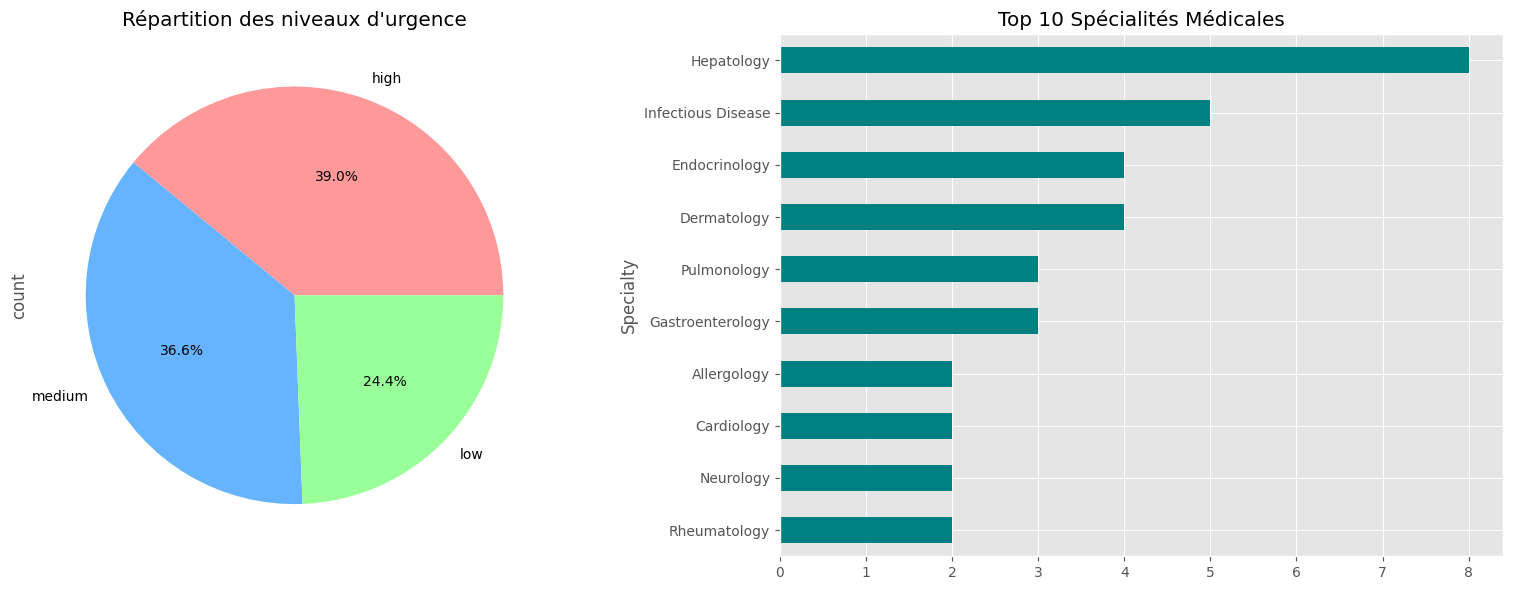

In [7]:
# Configuration style
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Distribution des Urgences
df_spec['Urgency'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1, colors=['#ff9999','#66b3ff','#99ff99'])
ax1.set_title('Répartition des niveaux d\'urgence')

# Graphique 2: Top 10 Spécialités
df_spec['Specialty'].value_counts().head(10).plot(kind='barh', ax=ax2, color='teal')
ax2.set_title('Top 10 Spécialités Médicales')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(f'{PROCESSED_PATH}medical_overview.png')
plt.show()

### 6. Conclusion pour le Data Processing
1. Le dataset est riche mais nécessite un nettoyage des **espaces blancs** et des **majuscules/minuscules**.
2. Le script de processing devra impérativement utiliser une fonction de **normalisation** (strip + lower) pour réconcilier `dataset.csv` et `medical_specialties.csv`.